# P10 - Détection de faux billets

### Sommaire

* [Chapitre 1: Introduction](#chapter1)
    * [Contexte](#section_1_1)
    * [Import des librairies](#section_1_2)
        
* [Chapitre 2: Import et exploration des données](#chapter2)
    * [Import et exploration](#section_2_1)
    * [Synthèse](#section_2_2)
    
* [Chapitre 3: Remplacement des valeurs manquantes par régression linéaire multiple](#chapter3)  
* [Chapitre 4: Prédiction du type du billet par régression logistique multiple](#chapter4)
* [Chapitre 5: Prédiction du type du billet par K-means](#chapter5)
* [Chapitre 6: Synthèse des méthodes de prédiction](#chapter6)
* [Chapitre 7: Test de la prédiction en soutenance](#chapter7)

        

## Chapitre 1: Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Contexte <a class="anchor" id="section_1_1"></a>

Data Analyst en prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM), ma mission est de mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets.
Mes données d'entrée sont certaines dimensions des billets.

### 1.2 Import des librairies <a class="anchor" id="section_1_2"></a>


In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

# Chargement des options
sns.set()
warnings.filterwarnings('ignore')

## Chapitre 2: Import et exploration des données <a class="anchor" id="chapter2"></a>

Nous allons importer les données, puis les explorer pour mieux les comprendre et détecter d'éventuelles anomalies.
- Structure des données
- Valeurs manquantes
- Lignes dupliquées
- Visualisation des variables par paire
- Corrélation des variables
- Outliers

### 2.1 Import et exploration <a class="anchor" id="section_2_1"></a>

In [2]:
#importation des données
df = pd.read_csv('billets.csv', sep=';')
df.head(5) #visu des 5 premières lignes

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Nous disposons actuellement de six informations géométriques sur un billet :
- diagonal : la diagonale du billet (en mm);
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- length : la longueur du billet (en mm).

#### Structure des données

In [3]:
df.shape

(1500, 7)

le dataset comprend 1500 lignes pour 7 colonnes.

In [4]:
df.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

Toutes les variables sont de types quanti sauf le type de billet qui est un booléen.

#### Valeurs manquantes

In [5]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

La variable 'margin_low' a des valeurs manquantes

In [6]:
df.isna().mean().round(2)

is_genuine      0.00
diagonal        0.00
height_left     0.00
height_right    0.00
margin_low      0.02
margin_up       0.00
length          0.00
dtype: float64

Cela correspond à 2% de ses valeurs. ==> Il faudra le traiter, nous le ferons par la suite.

#### Lignes dupliquées

In [7]:
df.duplicated().sum()

0

Il n'y a pas de ligne dupliquée.

#### Visualisation des variables

Observons la relation entre les variables 2 par 2.

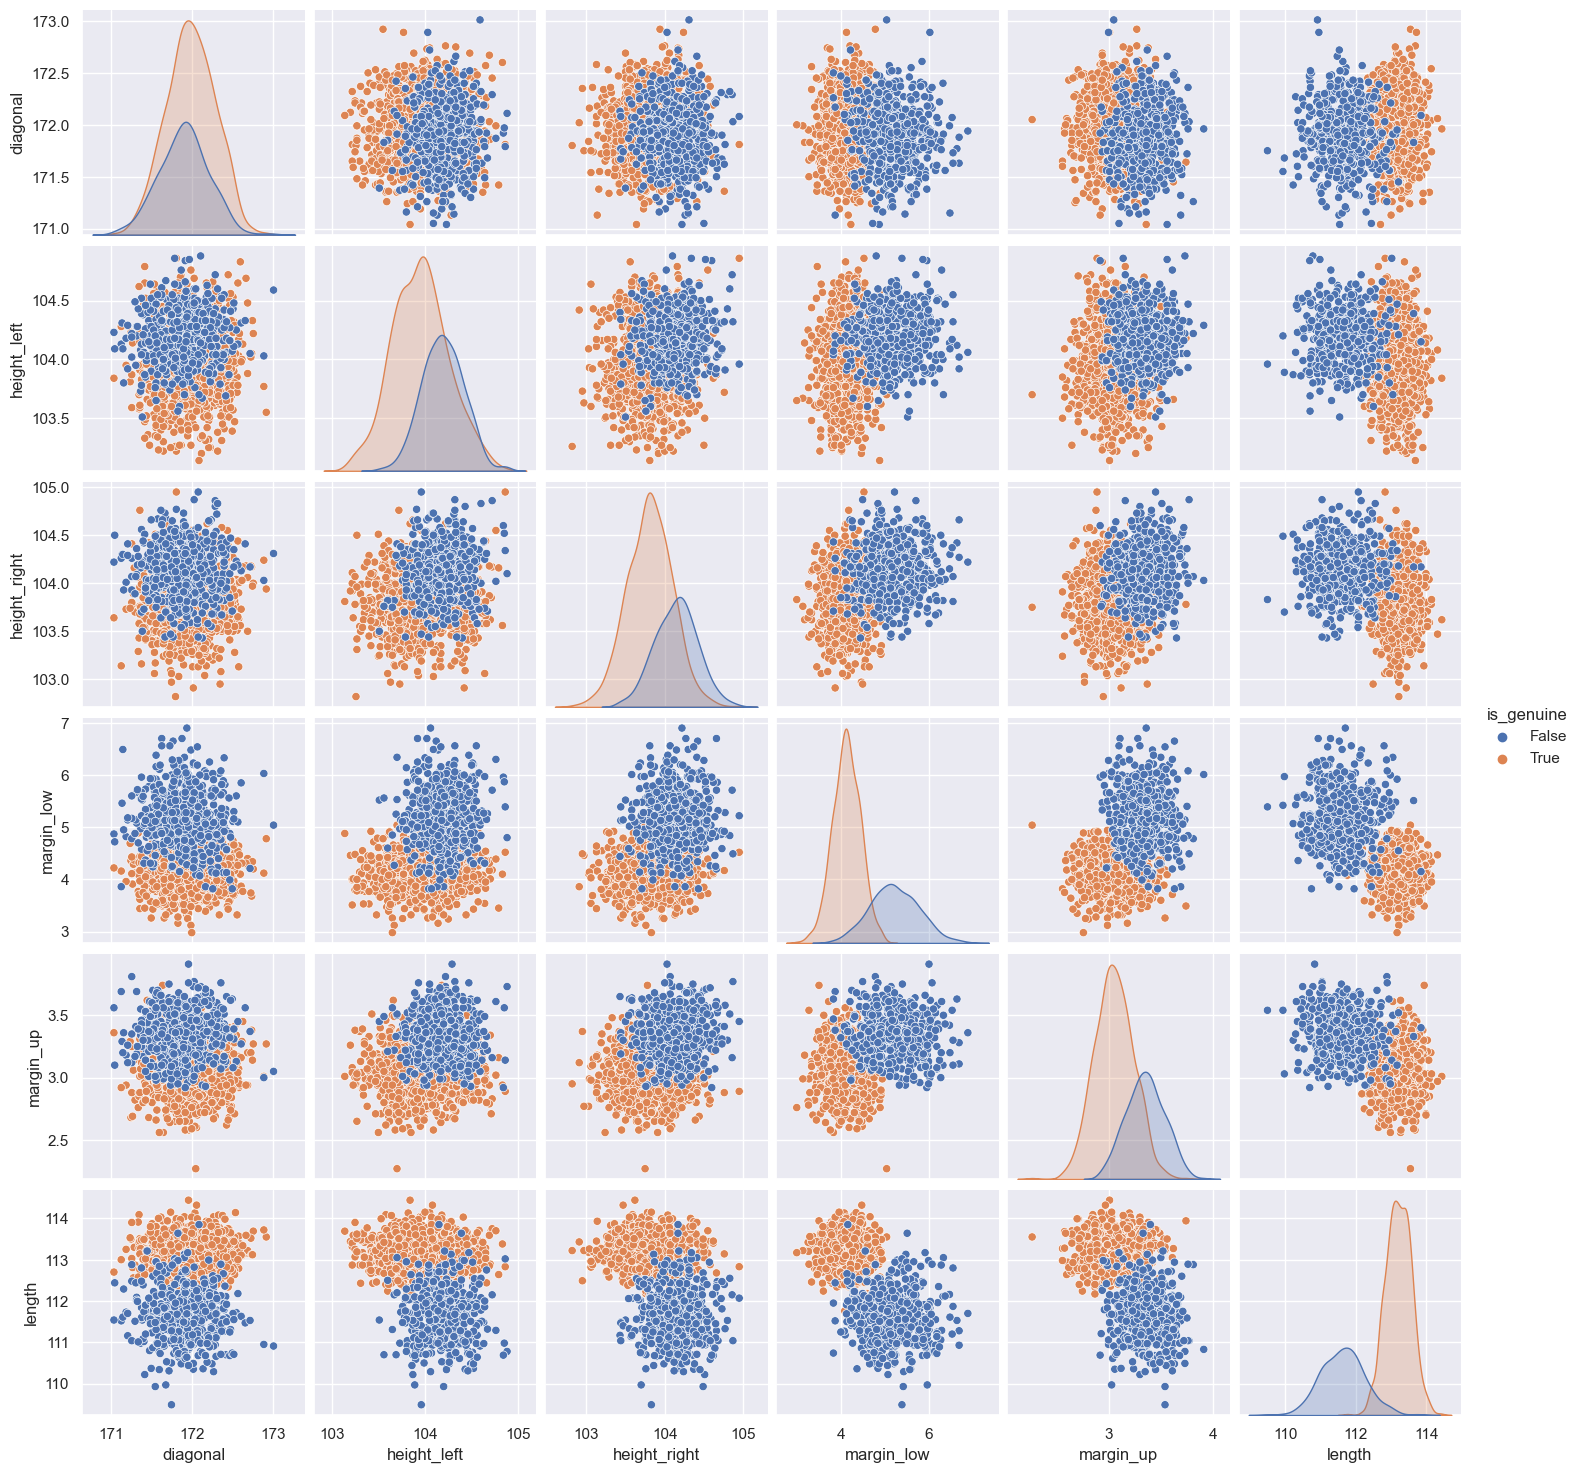

In [8]:
sns.pairplot(df, hue='is_genuine')

==> Les nuages de points semblent distincts.

Etudions la corrélation des variables:

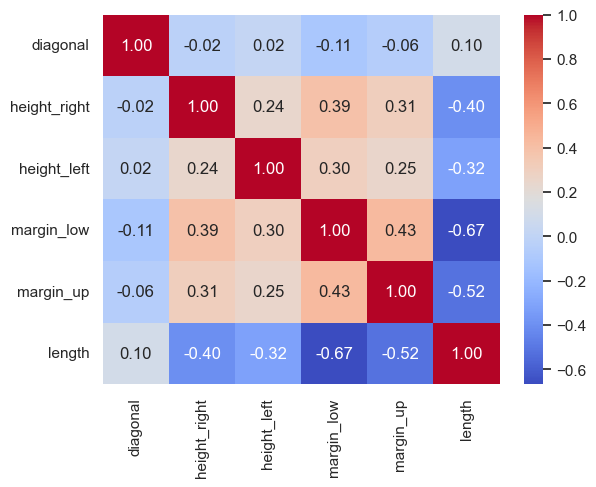

In [9]:
df_quanti = df[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]#enlever colonne is_genuine
corr = df_quanti.corr() 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

==> On observe une corrélation entre length et margin_low

#### Outliers

Visualisons les outliers et la distribution des valeurs, variable par variable.

<Axes: xlabel='length', ylabel='is_genuine'>

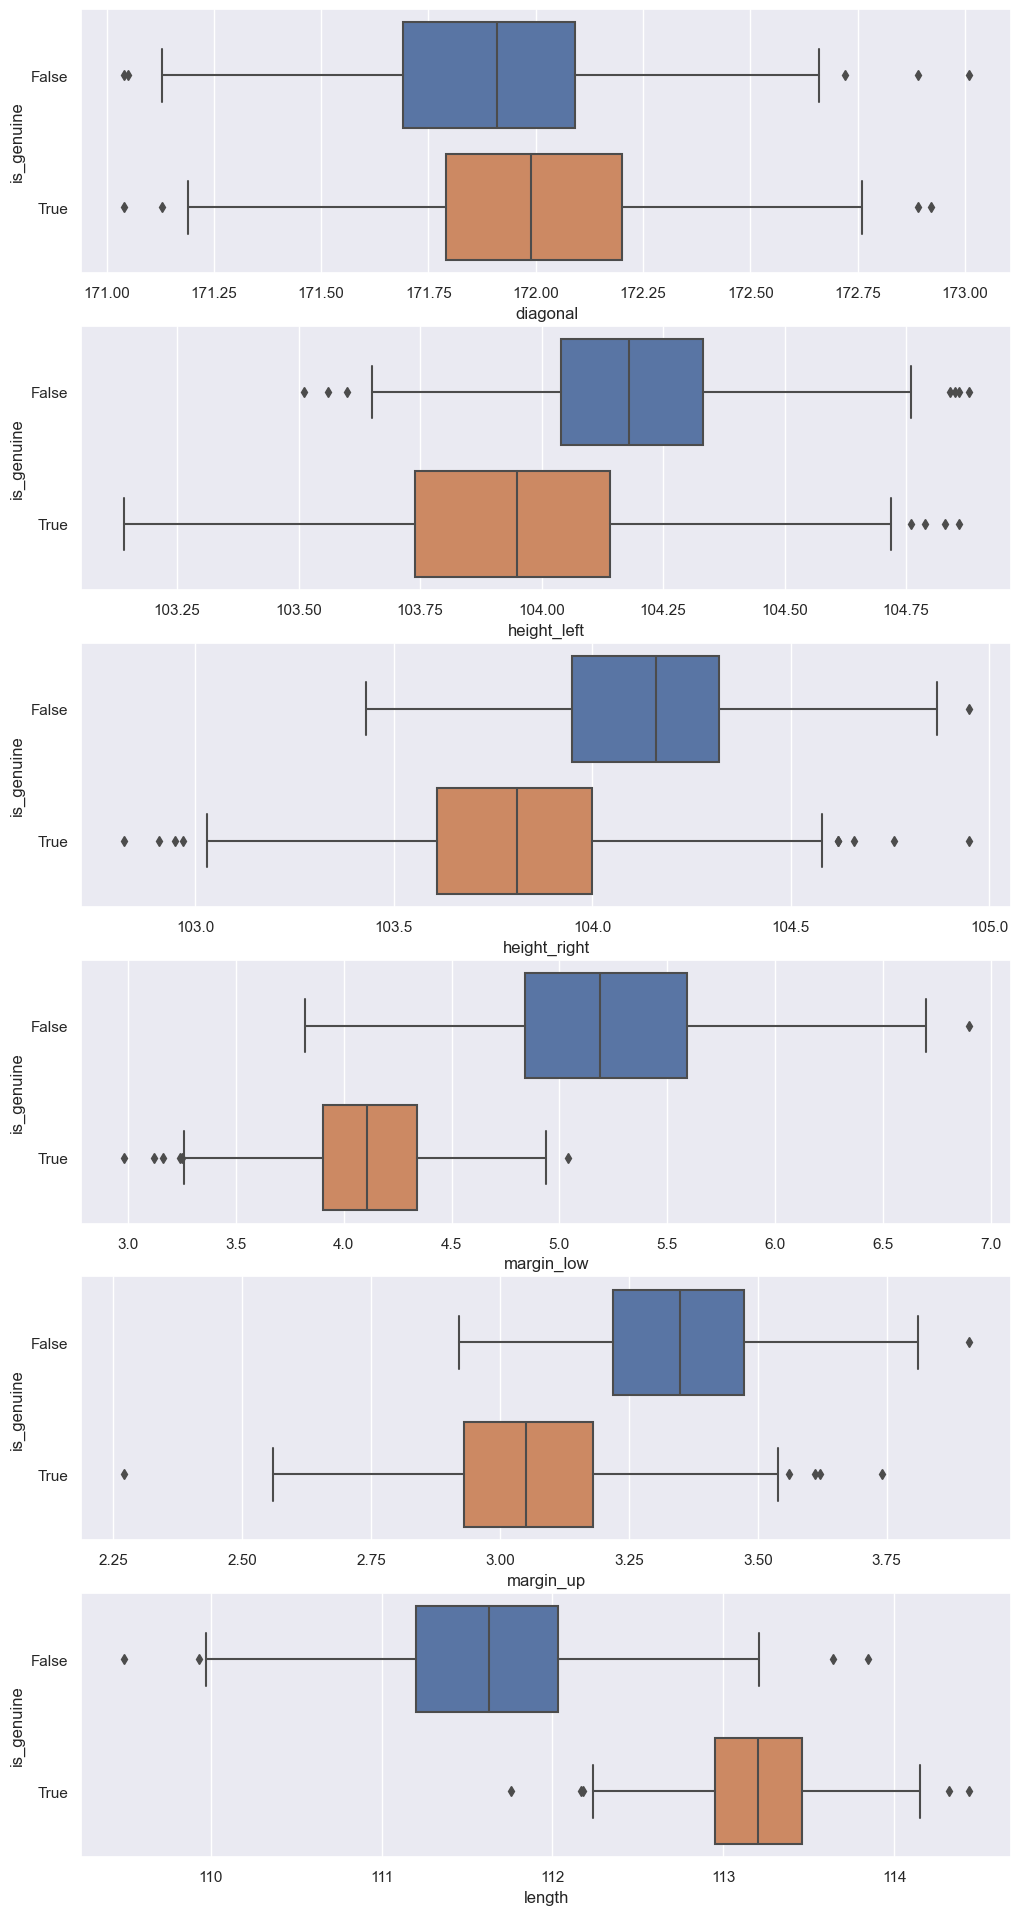

In [10]:
fig, axs = plt.subplots(6,1, figsize=(12,24))
sns.boxplot(df, ax=axs[0], orient="h", x='diagonal',y='is_genuine')
sns.boxplot(df, ax=axs[1], orient="h", x='height_left',y='is_genuine' )
sns.boxplot(df, ax=axs[2], orient="h", x='height_right',y='is_genuine')
sns.boxplot(df, ax=axs[3], orient="h", x='margin_low',y='is_genuine')
sns.boxplot(df, ax=axs[4], orient="h", x='margin_up',y='is_genuine')
sns.boxplot(df, ax=axs[5], orient="h", x='length',y='is_genuine')

==> pas d'anomalie sur les outliers, la distribution est cohérente.

True     1000
False     500
Name: is_genuine, dtype: int64


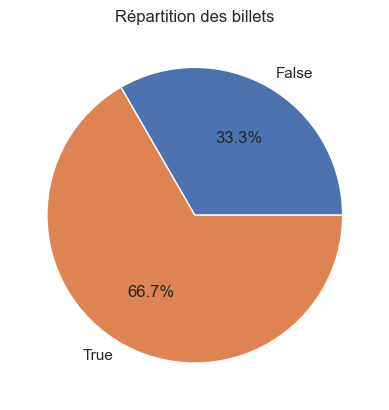

In [11]:
#nb de vrais et faux billets
Nb_vrai_faux = df['is_genuine'].value_counts()
print(Nb_vrai_faux)

#représentation graphique des proportions
plt.pie(df.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%")
#sns.axis("equal")
plt.title("Répartition des billets")
plt.show()

----------------------------------------------------------------------------------------------------------------------
### 2.2 Synthèse <a class="anchor" id="section_2_1"></a>


- Il y a 1500 billets dans le training set, 1000 vrais et 500 faux
- Lors de l'exploration des données par paire, on a observé des nuages de points distincts.
- L'analyse des box plots nous a permis d'observer que:
    - la variable 'diagonal' semble très proche pour les vrais et faux billets
    - la variable **'height_left'** montre une distribution plus large pour les vrais billets avec **une valeur moyenne inférieure aux billets faux.**
    - **idem pour la variable 'height_right'**
    - la variable **'margin_low'** a des valeurs pour les billets **vrais bien inférieures aux faux billets** (en dessous de la moyenne des faux billets)
    - la variable **'margin_up' aussi mais pas autant**.
    - la variable **'length'** a des valeurs pour les **vrais billets situés au dessus de la moyenne des faux billets**.
- La variable 'margin_low' a des valeurs manquantes. Nous allons les remplacer par régression linéaire.

## Chapitre 3: Remplacement des valeurs manquantes par régression linéaire multiple <a class="anchor" id="chapter3"></a>

Nous allons procéder au remplacement des valeurs manquantes de 'margin_low' par régression linéaire multiple. Pour cela, nous allons créer un modèle à partir de toutes les variables dont nous allons analyser la performance en vérifiant la colinéarité des variables, l'homoscédacité des résidus et la visualisation des résultats.

Puis nous allons prédire les valeurs de 'margin_low' à partir du modèle et remplacer uniquement les valeurs manquantes par les valeurs prédites.

Nous visualiserons l'impact des résultats sur la corrélation des variables et par paire de variable

In [12]:
#entrainement du modèle à partir de toutes les variables
marge_basse = ols('margin_low ~ diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(marge_basse.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          2.60e-202
Time:                        12:06:09   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

==> toutes les p-values sont inférieurs à 5%, les variables sont toutes significatives. 

Le coeficient de détermination R² vaut 0,477 tout comme le R² ajusté. Pour rappel, R² vaut entre 0 et 1:
- si R² vaut 1, cela signifie que toute la variable est expliquée par le modèle
- si R² vaut 0, au contraire aucune variable n'est expliquée par le modèle.

On cherche donc un R² qui tend vers 1.

### Vérifions la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [13]:
variables = marge_basse.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686315,
 1.1382605736082538,
 1.2301145155560338,
 1.404403778184362,
 1.5769501453665806]

==> Tous les coefficients sont inférieurs à 10, il n'y a donc **pas de problème de colinéarité.**

### Analysons l'homoscédasticité des résidus


Pour analyser nos résultats, on va tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :
- H0: homoscédasticité des résidus
- H1: hétéroscédasticité des résidus


In [14]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(marge_basse.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216194938e-16


p-value inférieure à 5%, L'hypothèse H0 est vérifiée.

==> **Homoscédacité des résidus**

### Prédiction des valeurs manquantes

En 2 étapes:
- 1/ prédiction à partir du modèle, nous en profiterons pour visualiser les résidus.
- 2/ remplacement uniquement pour les valeurs manquantes

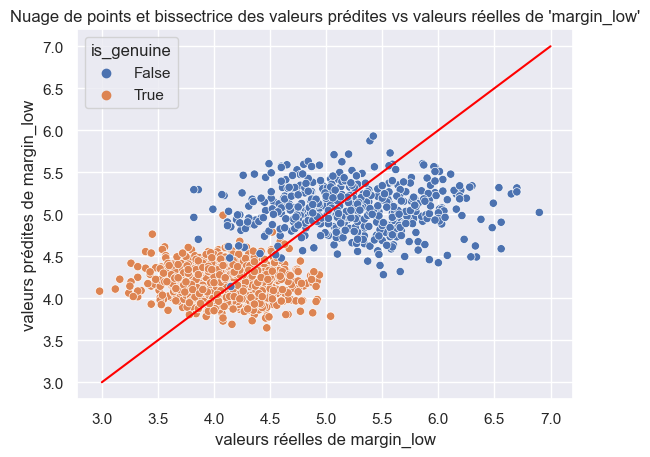

In [15]:
#Prédiction de la valeur de margin_low à partir du modèle
margin_low_lin= marge_basse.predict(df)#prediction de la valeur de margin_low
#transformer en df avec index conservé
df_margin_low_lin=pd.DataFrame(margin_low_lin)
#merge avec df selon les indexs (conservés)
df_merge=pd.merge(df_margin_low_lin,df, left_index=True, right_index=True, how='right')
#renommer la colonne
df_merge.rename(columns={0:'margin_low_pred'}, inplace=True)


#visualiser les résidus: valeurs prédites vs valeurs réelles
#plt.scatter(df_merge['margin_low'], df_merge['margin_low_pred'], marker='P')
sns.scatterplot(x='margin_low', y='margin_low_pred', data=df_merge, hue='is_genuine', ec=None)
plt.plot([3,7],[3,7], c='red')

plt.xlabel("valeurs réelles de margin_low")
plt.ylabel("valeurs prédites de margin_low")
plt.title ("Nuage de points et bissectrice des valeurs prédites vs valeurs réelles de 'margin_low'")
plt.show()

==> Pour aller plus loin, on note qu'en colorant les points par type de billet on voit bien 2 nuages distincts.

In [16]:
#remplacer valeurs manquantes par les valeurs prédites
df_merge.loc[df_merge['margin_low'].isna(),'margin_low']=df_merge['margin_low_pred']
#supprime la colonne inutile pour le df définitif df_cleaned
df_cleaned=df_merge.drop('margin_low_pred', axis=1)

Visualisons la régression linéaire:
- impact sur la matrice de corrélation
- graphes 2D entre margin_low et autres variables.

Regardons l'impact de la régression linéaire sur la matrice de corrélation: à gauche la matrice après la régression linéaire et à droite avant (données initiales).

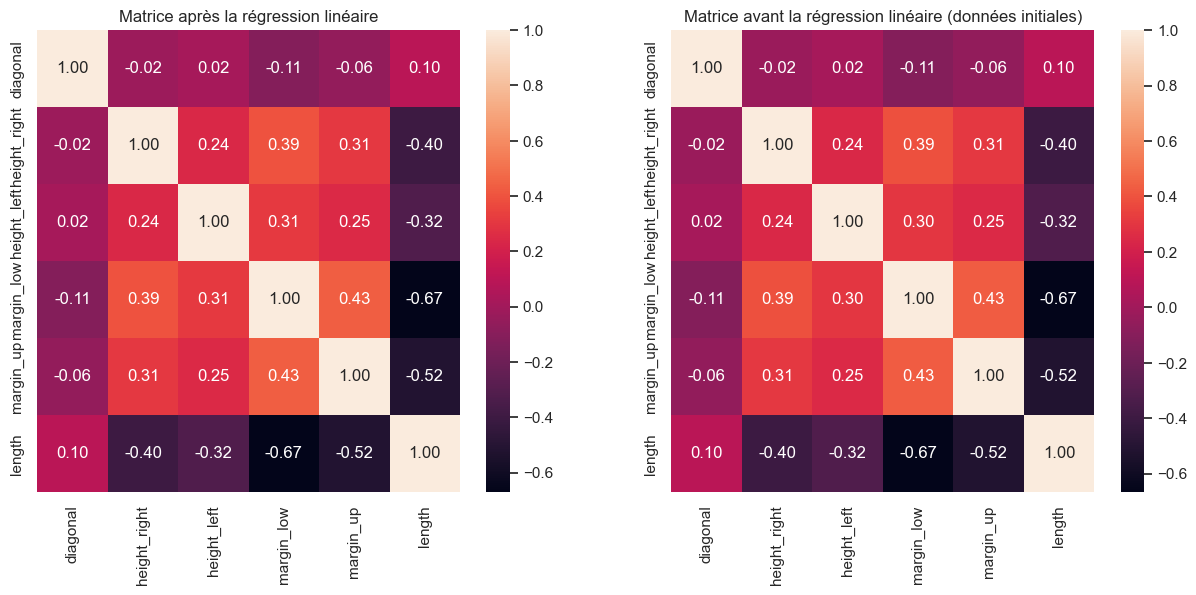

In [17]:
# création df avec variables quanti que l'on veut analyser ensuite:
df_quanti_cleaned = df_cleaned[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]#enlever colonne is_genuine
#matrice de corrélation en heatmap
corr_df_cleaned = df_quanti_cleaned.corr() 
plt.figure(figsize=(15, 6))
#Graphe 1: après regression
plt.subplot(1,2,1) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index)
sns.heatmap(corr_df_cleaned, annot=True, fmt=".2f")
plt.title('Matrice après la régression linéaire')


#Graphe 2: avant regression
plt.subplot(1,2,2) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Matrice avant la régression linéaire (données initiales)')
plt.show()

==> Pas d'impact sur la matrice de corrélation.

Visualisons en 2D, les variables correlées margin_low et length :

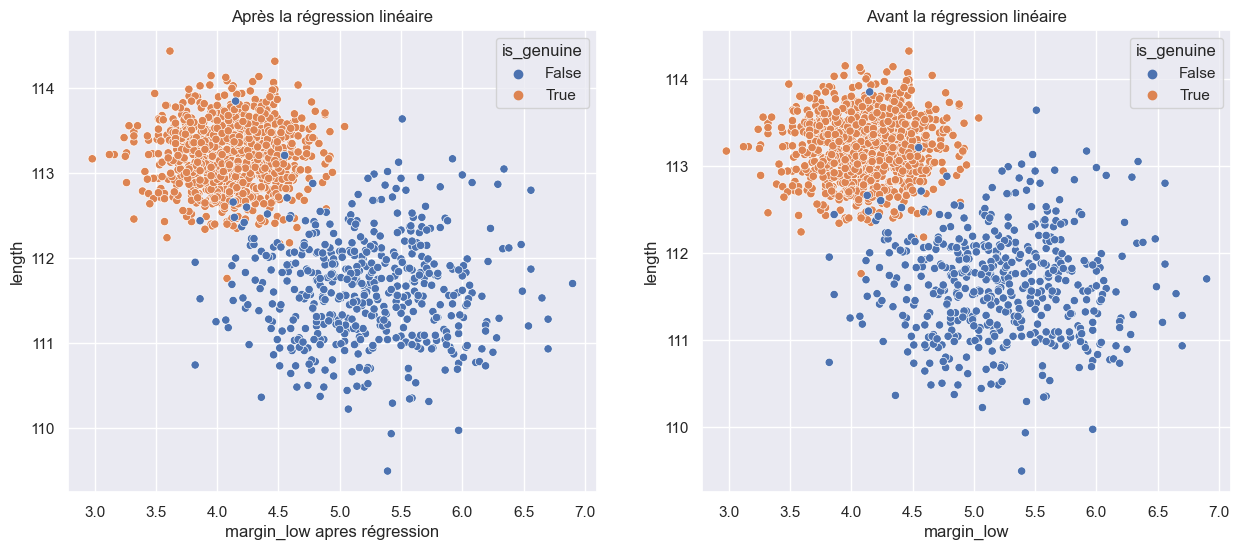

In [18]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df_cleaned, x='margin_low', y='length', hue='is_genuine')
plt.xlabel('margin_low apres régression')
plt.title('Après la régression linéaire')

plt.subplot(1,2,2)
sns.scatterplot(df, x='margin_low', y='length', hue='is_genuine')
plt.title('Avant la régression linéaire')

plt.show()

==> pas de modifications notables des 2 nuages de points.

Visualisons en 2D, les variables non-correlées margin_low et diagonal :

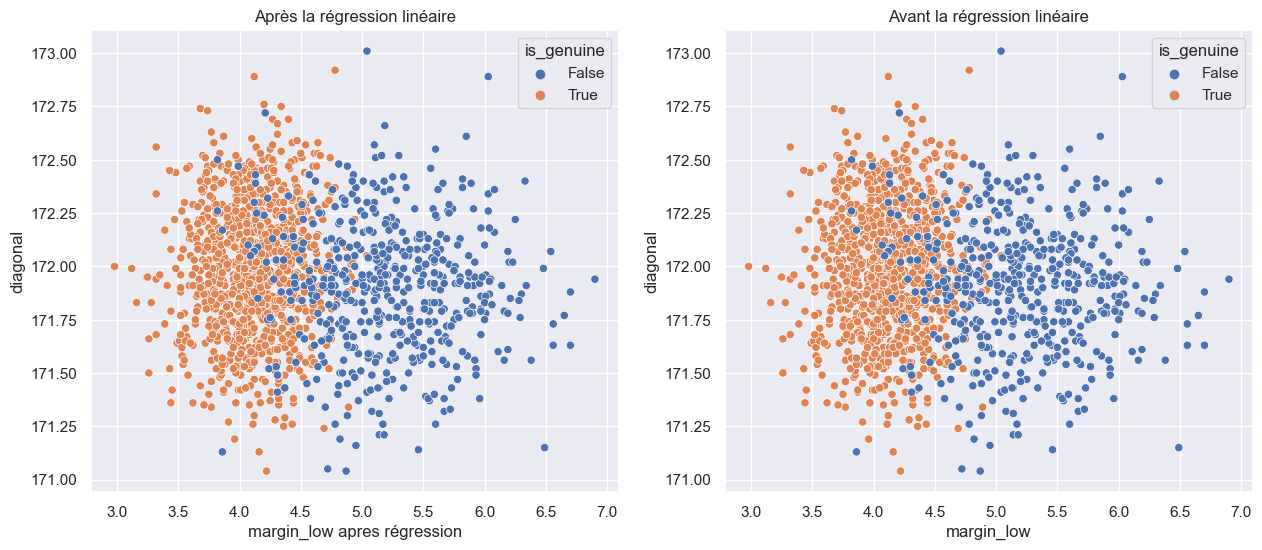

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df_cleaned, x='margin_low', y='diagonal', hue='is_genuine')
plt.xlabel('margin_low apres régression')
plt.title('Après la régression linéaire')

plt.subplot(1,2,2)
sns.scatterplot(df, x='margin_low', y='diagonal', hue='is_genuine')
plt.title('Avant la régression linéaire')

plt.show()

==> de même pas d'impact visible des nuages de points (moins) distincts.

Maintenant que nous avons un jeu de données complet et nettoyé. Nous allons créer les algorithmes de prédiction du type de billet selon 2 méthodes que nous comparerons ensuite:
- methode 1 : régression logistique
- méthode 2: k-means.

Pour les 2 méthodes, nous construirons le modèle sur un jeu d'entraînement puis le testerons sur un jeu de test.

## Chapitre 4: Prédiction du type du billet par régression logistique multiple <a class="anchor" id="chapter4"></a>

- Séparation jeu d'entrainement (xtrain et ytrain) et jeu de test (xtest et ytest)
- Création du modèle de régression logistique

In [20]:
#séparation des jeux d'entrainement et de test
X = df_cleaned[['diagonal','height_left','height_right','margin_low','margin_up','length']]
y= df_cleaned['is_genuine']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)


#Constitution d'un df commun df_train
ytrain_df=pd.DataFrame(ytrain)#transformation ytrain en dataframe
xtrain_df=pd.DataFrame(xtrain)#transformation xtrain en dataframe
#fusion des 2df avec l'index comme clé
df_train = pd.merge(ytrain_df,xtrain_df, left_index=True, right_index=True)
#commande glm pour régression logistique, avec famille binomial
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=df_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1193
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -37.419
Date:                                       Thu, 21 Sep 2023   Deviance:                       74.837
Time:                                               12:06:12   Pearson chi2:                 2.70e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7010
Covariance Type:                                   nonrobust                      

Certaines variables ont des p-values >5%, on va les retirer au fur et à mesure afin de ne conserver que les variables significatives.

In [21]:
#on retire 'diagonal'
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length',
                   data=df_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1194
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -37.434
Date:                                       Thu, 21 Sep 2023   Deviance:                       74.869
Time:                                               12:06:12   Pearson chi2:                 2.74e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7009
Covariance Type:                                   nonrobust                      

In [22]:
#on retire 'height_left'
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length',
                   data=df_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -38.556
Date:                                       Thu, 21 Sep 2023   Deviance:                       77.112
Time:                                               12:06:12   Pearson chi2:                 3.24e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7004
Covariance Type:                                   nonrobust                      

==> toutes les p-values sont inférieures à 5%, les variables sont significatives.

On applique le modèle sur le testing set:

In [23]:
#constitution d'un df de test
ytest_df=pd.DataFrame(ytest)#transformation ytest en dataframe
xtest_df=pd.DataFrame(xtest)#transformation xtest en dataframe
#fusion des 2df avec l'index comme clé
df_test = pd.merge(ytest_df,xtest_df, left_index=True, right_index=True)

#applique le modèle sur le jeu de test
prediction_log=reg_log.predict(df_test).round(0)
prediction_log_df=pd.DataFrame(prediction_log)

prediction_log_df.rename(columns={0:'type_pred_log'}, inplace=True)#renommer la colonne
#Fusion
df_test_log=pd.merge(df_test, prediction_log_df, left_index=True, right_index=True, how='left')

# Création d'une variable plus parlante de type True/False
df_test_log['bool_pred_log']= list(map(bool,df_test_log['type_pred_log'] ))
df_test_log['bool_pred_log'] = ~df_test_log['bool_pred_log']


On va constituer la matrice de confusion sur le jeu de test pour évaluer la performance du modèle.

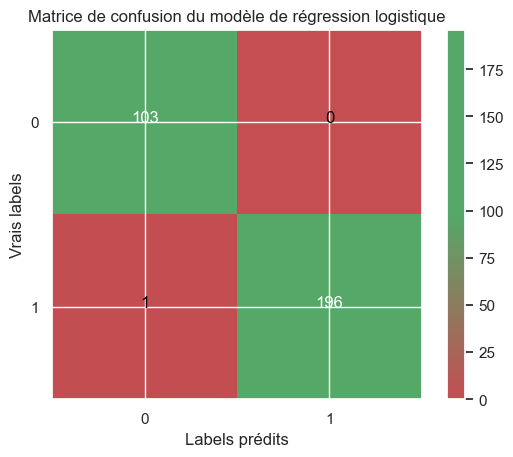

In [24]:
import itertools
from  matplotlib.colors import LinearSegmentedColormap
cnf_matrix = confusion_matrix(df_test_log['is_genuine'],df_test_log['bool_pred_log'])
classes = range(0,2)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap=LinearSegmentedColormap.from_list('rg',["r", "g", "g"], N=256))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.title('Matrice de confusion du modèle de régression logistique')
plt.show()

In [25]:
# calcul des TN true neg, FP False pos, FN False Neg, TP True Pos
tn, fp, fn ,tp = cnf_matrix.reshape(-1)
print('le modèle de regression logistique appliqué au jeu de test prédit:')
print('- le nb de vrai positif est',tp)
print('- le nb de vrai négatif est',tn)
print('- le nb de faux positif est',fp)
print('- le nb de faux négatif est',fn)
#calcul % d'erreur
erreur_log = ((fp+fn)*100/(fp+fn+tp+tn)).round(2)

print('==> le pourcentage d\'erreur de ce modèle est donc de', erreur_log,'%')

le modèle de regression logistique appliqué au jeu de test prédit:
- le nb de vrai positif est 196
- le nb de vrai négatif est 103
- le nb de faux positif est 0
- le nb de faux négatif est 1
==> le pourcentage d'erreur de ce modèle est donc de 0.33 %


## Chapitre 5: Prédiction du type du billet par K-means <a class="anchor" id="chapter5"></a>

- Choix du nombre de clusters
- Création du modèle de clustering à partir du jeu d'entraînement
- Prédiction des clusters sur le jeu de test

In [26]:
#scaling - instancie et entraine
std_scale=preprocessing.StandardScaler().fit(xtrain_df)
#scaling - transforme
X_scaled = std_scale.transform(xtrain_df)
#on vérifie que la moyenne est à 0 et l'écart-type à 1
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4,5
mean,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


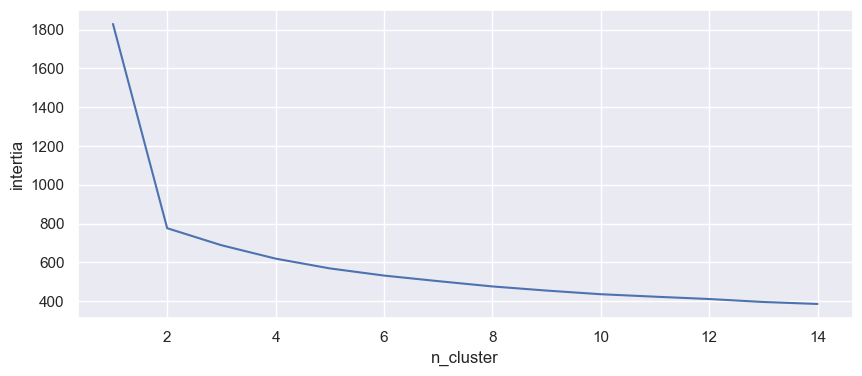

In [27]:
#K-means, méthode du coude (pour chaque nombre de clusters, on entraîne un k-means, et on enregistre la valeur de l'inertie) 
##########################
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 15)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(xtrain_df)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
    
#On construit le graphe pour constater la "cassure"
# en x le nb de clusters, en y la valeur de l'inertie intraclasse
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

==> la dernière cassure la plus forte est 2 et la pente est encore importante avec 4 clusters. On va effectuer un 1er k-means avec 4 clusters, puis un 2nd avec 2 clusters et comparer leur performance respective.

### K-means 4 clusters

In [28]:
#avec 4 clusters
n_clust = 4
kmeans = KMeans(n_clust)
kmeans.fit(xtrain_df)
clusters_k4 = kmeans.labels_ #récupération du N° de clusters issu du kmeans
centroids_k4 = kmeans.cluster_centers_ #et des centroides

On va analyser les clusters et indiquer quels sont les clusters correspondant aux vrais et aux faux billets

In [29]:
df_train['clusters_k4']=clusters_k4 #ajout de la colonne avec le n° de clusters issu du k-means
#on compte le nb de billets par n° de cluster et type de billets pour attribuer le type à chaque cluster
df_ana_clusters_k4 =df_train.groupby(['clusters_k4','is_genuine'])['diagonal'].count().reset_index(name='nb')
print('voici le détail par cluster du nb de billets vrais et faux:')
df_ana_clusters_k4

voici le détail par cluster du nb de billets vrais et faux:


,clusters_k4,is_genuine,nb
0,0,False,3
1,0,True,421
2,1,False,16
3,1,True,378
4,2,False,186
5,3,False,192
6,3,True,4


In [30]:
#définir le type du cluster df_train['type_k4']en attribuant à chaque le 'is_genuine' du nb max
df_type = pd.DataFrame()#on instancie un df vide
for n in range(4): #pour chaque cluster
    df= df_ana_clusters_k4.loc[df_ana_clusters_k4['clusters_k4']==n] #on isole que la partie de ce cluster
    nb_max = max(df['nb'])#on identifie le nb max du type de billets de ce cluster
    df['type_k4']=df.loc[df['nb']==nb_max]['is_genuine'] #on attribue la valeur de is_genuine au type du cluster
    df_type = df_type.append(df)#on ajoute à la fin du df 
    
df_type_cleaned_k4=df_type.dropna() #supprime les lignes avec valeurs manquantes
df_type_cleaned_k4.drop(['nb','is_genuine'], axis=1, inplace=True)#supprime les colonnes 
print('le kmeans à 4 clusters nous donne le résultat suivant:')
df_type_cleaned_k4


le kmeans à 4 clusters nous donne le résultat suivant:


,clusters_k4,type_k4
1,0,True
3,1,True
4,2,False
5,3,False


On va appliquer le modèle de k-means à 4 clusters sur le jeu de test pour obtenir un n° de cluster et estimer si le billet est donc vrai ou faux

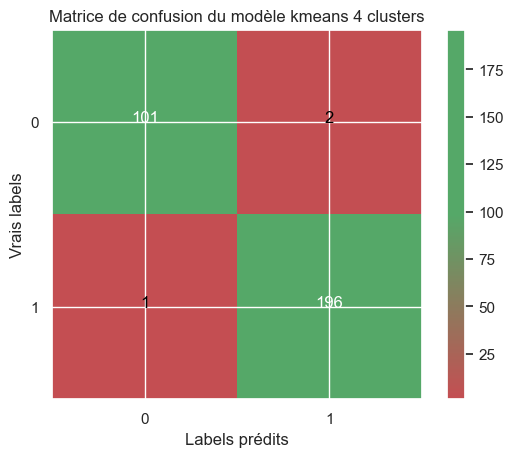

In [31]:
#on réinitialise l'index
df_test=df_test.reset_index()
#on ne conserve que les variables quanti
df_test_km=df_test[['diagonal', 'height_left','height_right','margin_low', 'margin_up','length']]
#applique le modèle sur le jeu de test
prediction_k4=kmeans.predict(df_test_km).round(0)
#on le transforme en dataframe
prediction_k4_df=pd.DataFrame(prediction_k4)
prediction_k4_df.rename(columns={0:'cluster_pred_k4'}, inplace=True)#renommer la colonne

#Fusion pour ajouter le n° de cluster prédit
df_test_kmeans4=pd.merge(df_test, prediction_k4_df, left_index=True, right_index=True, how='left')


#Fusion pour rattacher le type du cluster à chaque billet selon son n° de cluster
df_test_k4 = pd.merge(df_test_kmeans4, df_type_cleaned_k4, left_on='cluster_pred_k4' ,right_on='clusters_k4', how='left')
df_test_k4['bool_k4']=list(map(bool,df_test_k4['type_k4']))#force le type booléen


#matrice de confusion du kmeans à 4 clusters
cnf_matrix_k4 = confusion_matrix(df_test_k4['is_genuine'],df_test_k4['bool_k4'])
classes = range(0,2)
plt.figure()

plt.imshow(cnf_matrix_k4, interpolation='nearest',cmap=LinearSegmentedColormap.from_list('rg',["r", "g", "g"], N=256))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix_k4.shape[0]), range(cnf_matrix_k4.shape[1])):
    plt.text(j, i, cnf_matrix_k4[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix_k4[i, j] > ( cnf_matrix_k4.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.title('Matrice de confusion du modèle kmeans 4 clusters')
plt.show()

In [32]:
# calcul des TN true neg, FP False pos, FN False Neg, TP True Pos
tn_k4, fp_k4, fn_k4 ,tp_k4 = cnf_matrix_k4.reshape(-1)
print('le modèle de regression logistique appliqué au jeu de test prédit:')
print('- le nb de vrai positif est',tp_k4)
print('- le nb de vrai négatif est',tn_k4)
print('- le nb de faux positif est',fp_k4)
print('- le nb de faux négatif est',fn_k4)
#calcul % d'erreur
erreur_k4 = ((fp_k4+fn_k4)*100/(fp_k4+fn_k4+tp_k4+tn_k4)).round(2)

print('==> le pourcentage d\'erreur du modèle kmeans 4 clusters est donc de', erreur_k4,'%')

le modèle de regression logistique appliqué au jeu de test prédit:
- le nb de vrai positif est 196
- le nb de vrai négatif est 101
- le nb de faux positif est 2
- le nb de faux négatif est 1
==> le pourcentage d'erreur du modèle kmeans 4 clusters est donc de 1.0 %


On relance un k-means avec 2 clusters pour comparer les résultats.

In [33]:
#on refait avec 2 clusters pour évaluer le meilleur
n_clust = 2
kmeans = KMeans(n_clust)
kmeans.fit(xtrain_df)
clusters_k2 = kmeans.labels_ #récupération du N° de clusters issu du kmeans
centroids_k2 = kmeans.cluster_centers_ #et des centroides

In [34]:
df_train['clusters_k2']=clusters_k2 #ajout de la colonne avec le n° de clusters issu du k-means
#on compte le nb de billets par n° de cluster et type de billets pour voir les convergences
df_ana_clusters_k2 =df_train.groupby(['clusters_k2','is_genuine'])['diagonal'].count().reset_index(name='nb')
print('voici le détail par cluster du nb de billets vrais et faux:')
df_ana_clusters_k2

voici le détail par cluster du nb de billets vrais et faux:


,clusters_k2,is_genuine,nb
0,0,False,15
1,0,True,801
2,1,False,382
3,1,True,2


In [35]:
#définir le type du cluster df_train['type_k2']en attribuant à chaque le 'is_genuine' du nb max
df_type = pd.DataFrame()#on instancie un df vide
for n in range(2): #pour chaque cluster
    df= df_ana_clusters_k2.loc[df_ana_clusters_k2['clusters_k2']==n] #on isole que la partie de ce cluster
    nb_max = max(df['nb'])#on identifie le nb max du type de billets de ce cluster
    df['type_k2']=df.loc[df['nb']==nb_max]['is_genuine'] #on attribue la valeur de is_genuine au type du cluster
    df_type = df_type.append(df)#on ajoute à la fin du df 
    
df_type_cleaned_k2=df_type.dropna() #supprime les lignes avec valeurs manquantes
df_type_cleaned_k2.drop(['nb','is_genuine'], axis=1, inplace=True)#supprime les colonnes 
print('le kmeans à 2 clusters nous donne le résultat suivant:')
df_type_cleaned_k2


le kmeans à 2 clusters nous donne le résultat suivant:


,clusters_k2,type_k2
1,0,True
2,1,False


On va appliquer le modèle de k-means à 2 clusters sur le jeu de test pour obtenir un n° de cluster et estimer si le billet est donc vrai ou faux.

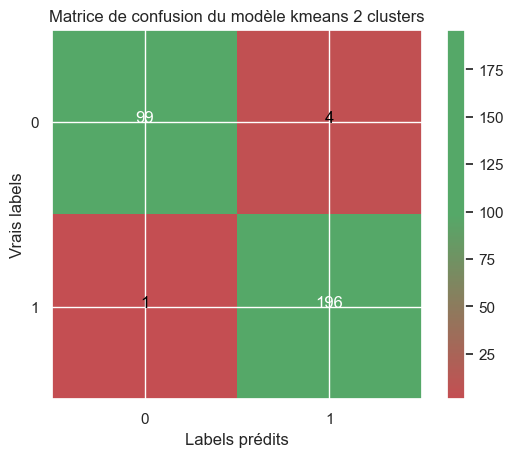

In [36]:
#applique le modèle sur le jeu de test
prediction_k2=kmeans.predict(df_test_km).round(0)
#on le transforme en dataframe
prediction_k2_df=pd.DataFrame(prediction_k2)
prediction_k2_df.rename(columns={0:'cluster_pred_k2'}, inplace=True)#renommer la colonne

#Fusion pour ajouter le n° de cluster prédit
df_test_kmeans2=pd.merge(df_test, prediction_k2_df, left_index=True, right_index=True, how='left')

#Fusion pour rattacher le type du cluster à chaque billet selon son n° de cluster
df_test_k2 = pd.merge(df_test_kmeans2, df_type_cleaned_k2, left_on='cluster_pred_k2' ,right_on='clusters_k2', how='left')
df_test_k2['bool_k2']=list(map(bool,df_test_k2['type_k2']))#force le type booléen


#matrice de confusion du kmeans à 4 clusters
cnf_matrix_k2 = confusion_matrix(df_test_k2['is_genuine'],df_test_k2['bool_k2'])
classes = range(0,2)
plt.figure()

plt.imshow(cnf_matrix_k2, interpolation='nearest',cmap=LinearSegmentedColormap.from_list('rg',["r", "g", "g"], N=256))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix_k2.shape[0]), range(cnf_matrix_k2.shape[1])):
    plt.text(j, i, cnf_matrix_k2[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix_k2[i, j] > ( cnf_matrix_k2.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.title('Matrice de confusion du modèle kmeans 2 clusters')
plt.show()

In [37]:
# calcul des TN true neg, FP False pos, FN False Neg, TP True Pos
tn_k2, fp_k2, fn_k2 ,tp_k2 = cnf_matrix_k2.reshape(-1)
print('le modèle de regression logistique appliqué au jeu de test prédit:')
print('- le nb de vrai positif est',tp_k2)
print('- le nb de vrai négatif est',tn_k2)
print('- le nb de faux positif est',fp_k2)
print('- le nb de faux négatif est',fn_k2)
#calcul % d'erreur
erreur_k2 = ((fp_k2+fn_k2)*100/(fp_k2+fn_k2+tp_k2+tn_k2)).round(2)

print('==> le pourcentage d\'erreur du modèle kmeans 2 clusters est donc de', erreur_k2,'%')

le modèle de regression logistique appliqué au jeu de test prédit:
- le nb de vrai positif est 196
- le nb de vrai négatif est 99
- le nb de faux positif est 4
- le nb de faux négatif est 1
==> le pourcentage d'erreur du modèle kmeans 2 clusters est donc de 1.67 %


## Chapitre 6: Synthèse des méthodes de prédiction <a class="anchor" id="chapter6"></a>

In [38]:
print('Le modèle de régression logistique donne une prédiction avec une erreur de', erreur_log,'%')

print('Le modèle kmeans à 4 clusters donne une prédiction avec une erreur de', erreur_k4,'%')

print('Le modèle kmeans à 2 clusters donne une prédiction avec une erreur de', erreur_k2,'%')


Le modèle de régression logistique donne une prédiction avec une erreur de 0.33 %
Le modèle kmeans à 4 clusters donne une prédiction avec une erreur de 1.0 %
Le modèle kmeans à 2 clusters donne une prédiction avec une erreur de 1.67 %


**==> Le modèle de régression logistique est celui dont le % d'erreur est le plus stable et le plus faible à chaque fois que j'ai fait tourné mon NB. C'est donc celui que nous allons utiliser pour le test de l'algorithme.**


## Chapitre 7: Test de la prédiction en soutenance <a class="anchor" id="chapter7"></a>

Nous importons les données, on visualise le dataframe vérifier que cela se fait correctement.

In [43]:
#importation des données du test
df_prod = pd.read_csv('billets_test.csv', sep=',')
#vérification que les données sont correctement importées
df_prod.head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [44]:
#applique le modèle sur le jeu de test
prediction_prod=reg_log.predict(df_prod).round(0)
prediction_prod_df=pd.DataFrame(prediction_prod)
prediction_prod_df.rename(columns={0:'type_pred_log'}, inplace=True)#renommer la colonne

#Fusion dans un df qui inclut les données d'entrée et la prédiction
df_prod_log=pd.merge(df_prod, prediction_prod_df, left_index=True, right_index=True, how='left')

#attribution du type de billet plus explicite
df_prod_log['bool_pred_log']= list(map(bool,df_prod_log['type_pred_log'] ))
df_prod_log['bool_pred_log'] =~df_prod_log['bool_pred_log']

# calcul du nb de billets via la fonction value_counts :
nb_billets = df_prod_log['bool_pred_log'].value_counts()


#affichage du résultat
print('Suite à la prédiction, nous obtenons le résultat suivant:')

df_prod_log[['diagonal','height_left','height_right','margin_low','margin_up','length','id', 'bool_pred_log']]



Suite à la prédiction, nous obtenons le résultat suivant:


,diagonal,height_left,height_right,margin_low,margin_up,length,id,bool_pred_log
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False


In [42]:
# On compte le nb de chaque type
nb = df_prod_log['bool_pred_log'].value_counts()
nb = pd.DataFrame(nb)
print('Soit par type de billets:')
nb

Soit par type de billets:


,bool_pred_log
False,3
True,2


**MERCI pour votre attention, avez-vous des questions?**